Tensorflow Python API

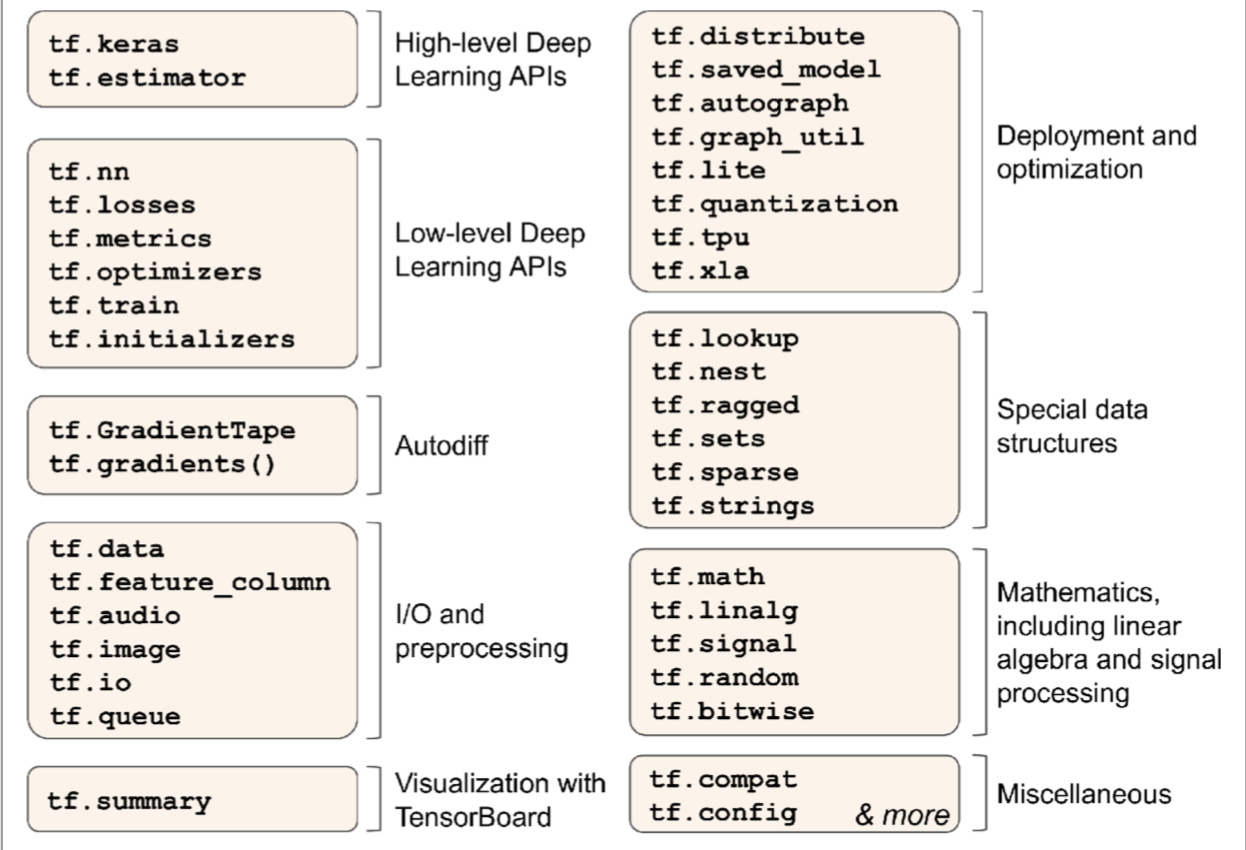

In [2]:
import tensorflow as tf

In [3]:
# Creating a tensor - which could be a matrix or a scalar.
tf.constant([[1., 2., 3.], [4., 5., 6.]]) # matrix

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[1., 2., 3.],
       [4., 5., 6.]], dtype=float32)>

In [4]:
 tf.constant(42) # scalar

<tf.Tensor: shape=(), dtype=int32, numpy=42>

In [5]:
t = tf.constant([[1., 2., 3.], [4., 5., 6.]])

In [6]:
t.shape

TensorShape([2, 3])

In [8]:
t.dtype

tf.float32

In [12]:
t[:,1]

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([2., 5.], dtype=float32)>

In [13]:
t[:,1,tf.newaxis]

<tf.Tensor: shape=(2, 1), dtype=float32, numpy=
array([[2.],
       [5.]], dtype=float32)>

NumPy uses 64-bit precision by default, while Tensor‐ Flow uses 32-bit. This is because 32-bit precision is generally more than enough for neural networks, plus it runs faster and uses less RAM. So when you create a tensor from a NumPy array, make sure to set dtype=tf.float32.

In [14]:
t2 = tf.constant(40., dtype=tf.float64)
tf.constant(2.0) + tf.cast(t2,tf.float32)

<tf.Tensor: shape=(), dtype=float32, numpy=42.0>

In [15]:
v = tf.Variable([[1., 2., 3.], [4., 5., 6.]]) #tf.Tensor is immutable so we need a variable

In [16]:
v.assign(2 * v)

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2.,  4.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [18]:
v[0,1].assign(-9) # assigning value to a specific index

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., -9.,  6.],
       [ 8., 10., 12.]], dtype=float32)>

In [19]:
v[:, 2].assign([0., 1.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[ 2., -9.,  0.],
       [ 8., 10.,  1.]], dtype=float32)>

In [20]:
# if you want to assign on a scatter basis
v.scatter_nd_update(indices=[[0, 0], [1, 2]], updates=[100., 200.])

<tf.Variable 'UnreadVariable' shape=(2, 3) dtype=float32, numpy=
array([[100.,  -9.,   0.],
       [  8.,  10., 200.]], dtype=float32)>

In [22]:
from tensorflow import keras 
import tensorflow as tf
from sklearn.datasets import fetch_california_housing 
from sklearn.model_selection import train_test_split 
from sklearn.preprocessing import StandardScaler

In [23]:
housing = fetch_california_housing()
X_train_full, X_test, y_train_full, y_test = train_test_split(housing.data, housing.target)
X_train, X_valid, y_train, y_valid = train_test_split(X_train_full, y_train_full)
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = scaler.transform(X_test)

In [24]:
model = keras.models.Sequential([
    keras.layers.Dense(30,activation="relu", input_shape=X_train.shape[1:]),
    keras.layers.Dense(1)
])

# Custom loss function

Regression loss when the data is noisy - Huber's loss

In [26]:
def huber_fn(y_true, y_pred):
    error = y_true - y_pred
    is_small_error = tf.abs(error) < 1
    squared_loss = tf.square(error) / 2
    linear_loss = tf.abs(error) - 0.5
    return tf.where(is_small_error, squared_loss, linear_loss)

In [27]:
model.compile(loss=huber_fn,optimizer="nadam")

In [28]:
model.fit(X_train,y_train,epochs=5,validation_data=(X_valid,y_valid))

Train on 11610 samples, validate on 3870 samples
Epoch 1/5
11610/11610 [==============================] - 1s 73us/sample - loss: 0.5772 - val_loss: 0.2595
Epoch 2/5
11610/11610 [==============================] - 0s 34us/sample - loss: 0.2433 - val_loss: 0.2062
Epoch 3/5
11610/11610 [==============================] - 0s 32us/sample - loss: 0.2076 - val_loss: 0.1872
Epoch 4/5
11610/11610 [==============================] - 0s 33us/sample - loss: 0.1923 - val_loss: 0.1792
Epoch 5/5
11610/11610 [==============================] - 0s 36us/sample - loss: 0.1856 - val_loss: 0.1727


In [29]:
model.save('custom_loss.h5')

In [30]:
# Loading the model
saved_model = keras.models.load_model('custom_loss.h5')

ValueError: Unknown loss function:huber_fn

In [32]:
# Loading the model, pass a dictionary with the custom loss function.
saved_model = keras.models.load_model('custom_loss.h5', custom_objects={"huber_fn":huber_fn})

### Configured Loss Function

In [33]:
# previous lossfunction was hardcoded - This is parameterized.

def create_huber(threshold=1.0): 
    def huber_fn(y_true, y_pred):
        error = y_true - y_pred
        is_small_error = tf.abs(error) < threshold
        squared_loss = tf.square(error) / 2
        linear_loss = threshold * tf.abs(error) - threshold**2 / 2 
        return tf.where(is_small_error, squared_loss, linear_loss)
    return huber_fn

In [34]:
model.compile(loss=create_huber(2.0), optimizer="nadam")

Unfortunately, when you save the model, the threshold will not be saved. This means that you will have to specify the threshold value when loading the model. Extend the Loss class to be better the threshold. 

In [35]:
#model = keras.models.load_model("my_model_with_a_custom_loss_threshold_2.h5",
#                                custom_objects={"huber_fn": create_huber(2.0)})

In [36]:
class HuberLoss(keras.losses.Loss):
    
    def __init__(self, threshold=1.0, **kwargs):
        
        self.threshold = threshold
        super().__init__(**kwargs) 

    def call(self, y_true, y_pred):
        
        error = y_true - y_pred
        is_small_error = tf.abs(error) < self.threshold
        squared_loss = tf.square(error) / 2
        linear_loss = self.threshold * tf.abs(error) - self.threshold**2 / 2 
        return tf.where(is_small_error, squared_loss, linear_loss)
    
    def get_config(self):
        
        base_config = super().get_config()
        return {**base_config, "threshold": self.threshold}

In [ ]:
#model = keras.models.load_model("my_model_with_a_custom_loss_class.h5",
#                                    custom_objects={"HuberLoss": HuberLoss})

In [39]:
#Custom Activation Functions, Initializers, Regularizers, and Constraints

In [37]:
def my_softplus(z): # return value is just tf.nn.softplus(z) 
    return tf.math.log(tf.exp(z) + 1.0)

def my_glorot_initializer(shape, dtype=tf.float32):
    stddev = tf.sqrt(2. / (shape[0] + shape[1]))
    return tf.random.normal(shape, stddev=stddev, dtype=dtype)

def my_l1_regularizer(weights):
    return tf.reduce_sum(tf.abs(0.01 * weights))

def my_positive_weights(weights): # return value is just tf.nn.relu(weights) 
    return tf.where(weights < 0., tf.zeros_like(weights), weights)


In [38]:
layer = keras.layers.Dense(30, activation=my_softplus,
                               kernel_initializer=my_glorot_initializer,
                               kernel_regularizer=my_l1_regularizer,
                               kernel_constraint=my_positive_weights)

The activation function will be applied to the output of this Dense layer, and its result will be passed on to the next layer. The layer’s weights will be initialized using the value returned by the initializer. At each training step the weights will be passed to the regularization function to compute the regularization loss, which will be added to the main loss to get the final loss used for training. Finally, the constraint function will be called after each training step, and the layer’s weights will be replaced by the con‐ strained weights.

In [41]:
# Using Streaming Metrics
precision = keras.metrics.Precision()
precision([0, 1, 1, 1, 0, 1, 0, 1], [1, 1, 0, 1, 0, 1, 0, 1]) ## True labels and predictions after batch one
precision([0, 1, 0, 0, 1, 0, 1, 1], [1, 0, 1, 1, 0, 0, 0, 0])## True labels and predictions after batch two

# Using a streaming metric to describe the entire precision and recall
precision.result()

<tf.Tensor: shape=(), dtype=float32, numpy=0.5>

In [42]:
precision.variables

[<tf.Variable 'true_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>,
 <tf.Variable 'false_positives:0' shape=(1,) dtype=float32, numpy=array([4.], dtype=float32)>]